In [92]:
import os
import pandas as pd
import yaml

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.legend_handler import HandlerTuple
import seaborn as sns

sns.set_theme()

In [93]:
# root_dir = r".\results\2024Apr07-010207_configs"
root_dir = r".\results\2024Apr09-184737_configs"


In [94]:
def collect_experiment_data(root_dir):
    """
    Collects experiment data and selected parameters from configuration files across multiple runs.

    Parameters:
    - root_dir: The root directory where experiment results are stored.

    Returns:
    - A pandas DataFrame containing the collected data and parameters.
    """
    all_data = []

    # Walk through the directory structure
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith("loss_record_combined.csv"):
                # Path to the current file
                file_path = os.path.join(subdir, file)
                # Read the loss record CSV file
                df = pd.read_csv(file_path)

                # Load the corresponding cfg.yaml file to get parameters
                cfg_path = os.path.join(subdir, "cfg.yaml")
                try:
                    with open(cfg_path, "r") as cfg_file:
                        cfg_data = yaml.safe_load(cfg_file)
                except FileNotFoundError:
                    print(f"Configuration file not found for {file_path}. Skipping...")
                    continue

                # Extract needed parameters, handle missing data gracefully
                run_id = cfg_data.get(
                    "run_id", "unknown"
                )  # Provide default values if key is missing
                tau = cfg_data.get("tau", 0)  # Default value if missing
                min_samples = cfg_data.get("min_samples", 0)  # Default value if missing

                # Add parameters as new columns to the DataFrame
                df["run_id"] = run_id
                df["tau"] = tau
                df["min_samples"] = min_samples

                # Append to the list of all data
                all_data.append(df)

    # Concatenate all data into a single DataFrame if not empty, otherwise return an empty DataFrame
    if all_data:
        return pd.concat(all_data, ignore_index=True)


combined_data = collect_experiment_data(root_dir)
combined_data

aggregated_df = (
    combined_data.groupby(["run_id", "tau", "min_samples"])
    .agg({"epoch": "max"})
    .reset_index()
)

aggregated_df

run_id    tau  min_samples  epoch
0        0  0.001           10     19
1        0  0.010           10     19
2        0  0.100           10     19
3        0  1.000           10     19
4        1  0.001           10     19
5        1  0.010           10     19
6        1  0.100           10     19
7        1  1.000           10     19
8        2  0.001           10     19
9        2  0.010           10     19
10       2  0.100           10     19
11       2  1.000           10     19
12       3  0.001           10     19
13       3  0.010           10     19
14       3  0.100           10     19
15       3  1.000           10     19
16       4  0.001           10     19
17       4  0.010           10     19
18       4  0.100           10     19
19       4  1.000           10     19

In [95]:
def tuple_constructor(loader, node):
    return tuple(loader.construct_sequence(node))

def generic_constructor(loader, tag_suffix, node):
    if isinstance(node, yaml.MappingNode):
        # Attempt to handle unhashable keys by converting them to a string representation
        # This is a workaround and might need adjustment based on specific use cases
        return {str(loader.construct_object(key)): loader.construct_object(value) for key, value in node.value}
    elif isinstance(node, yaml.SequenceNode):
        return [loader.construct_object(child) for child in node.value]
    elif isinstance(node, yaml.ScalarNode):
        return loader.construct_scalar(node)

yaml.SafeLoader.add_constructor('tag:yaml.org,2002:python/tuple', tuple_constructor)
yaml.SafeLoader.add_multi_constructor('', generic_constructor)

def collect_bellman_errors(root_dir):
    all_errors = []

    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith("bellman_error_combined.csv"):
                file_path = os.path.join(subdir, file)
                df_errors = pd.read_csv(file_path)

                cfg_path = os.path.join(subdir, "post_cfg.yaml")
                with open(cfg_path, "r") as cfg_file:
                    cfg_data = yaml.safe_load(cfg_file)

                for param, value in cfg_data.items():
                    if isinstance(value, dict):
                        for sub_param, sub_value in value.items():
                            df_errors[f"{param}_{sub_param}"] = sub_value
                    else:
                        df_errors[param] = value

                all_errors.append(df_errors)

    if all_errors:
        return pd.concat(all_errors)
    else:
        raise ValueError("No CSV files found in the specified directory.")
    

# Example usage (assuming `root_dir` is defined)
bellman_errors_df = collect_bellman_errors(root_dir)

bellman_errors_df

model  bellman_error  alpha  batch_size  cfg_id  cols  \
0       qnet_original       0.013656    0.1          32       0    10   
1  qnet_adjusted_loss       0.118781    0.1          32       0    10   
0       qnet_original       0.010336    0.1          32       0    10   
1  qnet_adjusted_loss       0.026228    0.1          32       0    10   
0       qnet_original       0.014888    0.1          32       0    10   
1  qnet_adjusted_loss       0.015298    0.1          32       0    10   
0       qnet_original       0.027896    0.1          32       0    10   
1  qnet_adjusted_loss       0.048336    0.1          32       0    10   
0       qnet_original       0.000132    0.1          32       0    10   
1  qnet_adjusted_loss       0.019234    0.1          32       0    10   
0       qnet_original       0.012866    0.1          32       1    10   
1  qnet_adjusted_loss       0.018758    0.1          32       1    10   
0       qnet_original       0.056526    0.1          32       1    10   
1  qnet_adjusted_loss       0.034332    0.1          32       1    10   
0       qnet_original       0.004435    0.1          32       1    10   
1  qnet_adjusted_loss       0.015906    0.1          32       1    10   
0       qnet_original       0.003544    0.1          32       1    10   
1  qnet_adjusted_loss       0.019177    0.1          32       1    10   
0       qnet_original       0.003921    0.1          32       1    10   
1  qnet_adjusted_loss       0.024762    0.1          32       1    10   
0       qnet_original       0.031767    0.1          32       2    10   
1  qnet_adjusted_loss       0.023667    0.1          32       2    10   
0       qnet_original       0.028910    0.1          32       2    10   
1  qnet_adjusted_loss       0.021169    0.1          32       2    10   
0       qnet_original       0.004201    0.1          32       2    10   
1  qnet_adjusted_loss       0.020562    0.1          32       2    10   
0       qnet_original       0.017737    0.1          32       2    10   
1  qnet_adjusted_loss       0.019038    0.1          32       2    10   
0       qnet_original       0.002724    0.1          32       2    10   
1  qnet_adjusted_loss       0.030181    0.1          32       2    10   
0       qnet_original       0.019400    0.1          32       3    10   
1  qnet_adjusted_loss       0.019394    0.1          32       3    10   
0       qnet_original       0.003936    0.1          32       3    10   
1  qnet_adjusted_loss       0.011641    0.1          32       3    10   
0       qnet_original       0.012135    0.1          32       3    10   
1  qnet_adjusted_loss       0.014110    0.1          32       3    10   
0       qnet_original       0.019347    0.1          32       3    10   
1  qnet_adjusted_loss       0.016619    0.1          32       3    10   
0       qnet_original       0.043867    0.1          32       3    10   
1  qnet_adjusted_loss       0.029496    0.1          32       3    10   

   epsilon                experiment  experiment_arguments_min_samples  \
0     0.01  experiment_distributions                                10   
1     0.01  experiment_distributions                                10   
0     0.01  experiment_distributions                                10   
1     0.01  experiment_distributions                                10   
0     0.01  experiment_distributions                                10   
1     0.01  experiment_distributions                                10   
0     0.01  experiment_distributions                                10   
1     0.01  experiment_distributions                                10   
0     0.01  experiment_distributions                                10   
1     0.01  experiment_distributions                                10   
0     0.01  experiment_distributions                                10   
1     0.01  experiment_distributions                                10   
0     0.01  experiment_distributions                        

In [96]:
bellman_errors_df["seed"]

0     128163600
1     128163600
0    2411434720
1    2411434720
0    3372190647
1    3372190647
0    1832902453
1    1832902453
0    1034463741
1    1034463741
0    4230120597
1    4230120597
0    4255788625
1    4255788625
0    1214992738
1    1214992738
0     672615160
1     672615160
0    3582244057
1    3582244057
0    1072933249
1    1072933249
0    3471664490
1    3471664490
0    2301942053
1    2301942053
0     814936300
1     814936300
0     111027943
1     111027943
0    3283384472
1    3283384472
0    2778915812
1    2778915812
0    3862129534
1    3862129534
0    1153551926
1    1153551926
0     916133638
1     916133638
Name: seed, dtype: int64

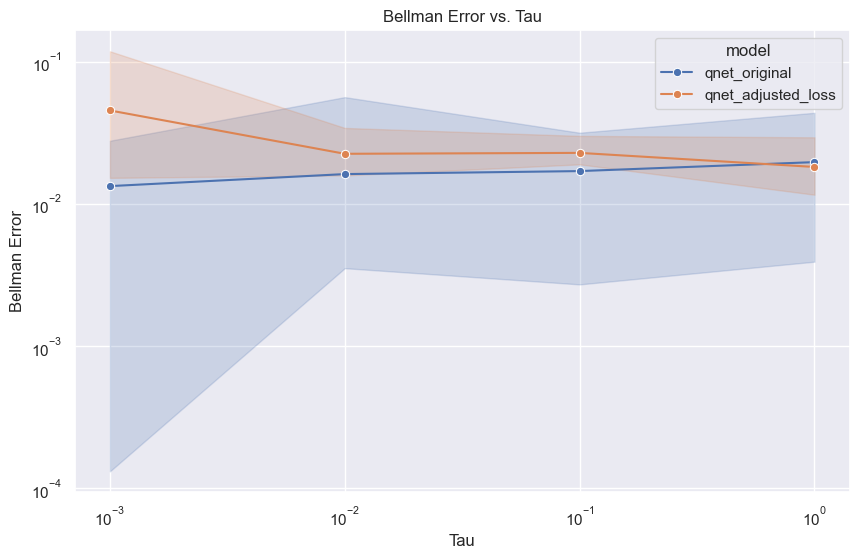

In [97]:

plt.figure(figsize=(10, 6))

# Plot experiment data
sns.lineplot(data=bellman_errors_df, x="tau", y="bellman_error", 
             hue="model",
             marker="o", errorbar=("pi", 100))


# Adjustments to plot aesthetics
plt.xlabel("Tau")
plt.ylabel("Bellman Error")
plt.xscale("log")
plt.yscale("log")
plt.title("Bellman Error vs. Tau")

plt.show()



In [98]:
bellman_errors_df.iloc[0]

model                                                                   qnet_original
bellman_error                                                                0.013656
alpha                                                                             0.1
batch_size                                                                         32
cfg_id                                                                              0
cols                                                                               10
epsilon                                                                          0.01
experiment                                                   experiment_distributions
experiment_arguments_min_samples                                                   10
experiment_arguments_tau                                                        0.001
full_title                          2024Apr09-184737_configs_tau=0.001; min_sample...
gamma                                                 

In [99]:
# With access to seeds, check why some examles have much lower bellman errors:

from experiment_src import (
    train_net_with_value_function_approximation,
    generate_random_policy_transitions,
    generate_transitions_observations,
    generate_train_test_split_with_valid_path,
    make_env
)
from experiments.experiment_utils import setup_logger, seed_everything

seed = 3
start_state = (0, 0)
terminal_states = {(8, 8): 1}
rows = 10
cols = 10
p_success = 1.0
num_steps = 40_000
tau = 10
min_samples = 20

def experiment_sample(seed, start_state, terminal_states, rows, cols, p_success, num_steps, tau, min_samples):
    seed_everything(seed)
    np.random.seed(seed)

    env = make_env(rows, cols, start_state, p_success, terminal_states, seed)

    states = list(set([s for s, _ in env.mdp.keys()]))
    actions = list(set([a for _, a in env.mdp.keys()]))

    transitions_list = [(key[0], key[1], *value[0]) for key, value in env.mdp.items()]

    transitions_train, transitions_val = generate_train_test_split_with_valid_path(
        transitions_list=transitions_list,
        start_state=start_state,
        terminal_states=terminal_states,
    )

    train_dataset_transitions = generate_transitions_observations(
        transitions_train, num_steps, tau, min_samples=min_samples
    )
    
    return train_dataset_transitions

samples = experiment_sample(seed, start_state, terminal_states, rows, cols, p_success, num_steps, tau, min_samples)

In [100]:
def sum_rewards(transitions):
    return sum(transition[3] for transition in transitions)

def count_transitions_terminal(transitions, target_value=1.0):
    transition_counts = {}
    for transition in transitions:
        if transition[3] == target_value:
            key = tuple(transition[:3])
            transition_counts[key] = transition_counts.get(key, 0) + 1
    return transition_counts

def count_transitions(transitions):
    transition_counts = {}
    for transition in transitions:
        key = tuple(transition[:3])
        transition_counts[key] = transition_counts.get(key, 0) + 1
    return transition_counts

samples = experiment_sample(seed, start_state, terminal_states, rows, cols, p_success, num_steps, tau, min_samples)

sum_rewards(samples)
t_counts = count_transitions(samples)
# len(t_counts)
t_counts

{((5, 4), <Action.DOWN: 2>, (6, 4)): 118,
 ((2, 9), <Action.UP: 0>, (1, 9)): 134,
 ((2, 4), <Action.LEFT: 3>, (2, 3)): 122,
 ((7, 6), <Action.LEFT: 3>, (7, 5)): 126,
 ((7, 4), <Action.LEFT: 3>, (7, 3)): 131,
 ((2, 0), <Action.LEFT: 3>, (2, 0)): 122,
 ((4, 1), <Action.RIGHT: 1>, (4, 2)): 138,
 ((0, 6), <Action.LEFT: 3>, (0, 5)): 113,
 ((3, 8), <Action.DOWN: 2>, (4, 8)): 120,
 ((2, 6), <Action.RIGHT: 1>, (2, 7)): 120,
 ((0, 7), <Action.DOWN: 2>, (1, 7)): 121,
 ((5, 2), <Action.UP: 0>, (4, 2)): 131,
 ((0, 9), <Action.DOWN: 2>, (1, 9)): 116,
 ((7, 9), <Action.DOWN: 2>, (8, 9)): 120,
 ((2, 6), <Action.DOWN: 2>, (3, 6)): 128,
 ((6, 7), <Action.UP: 0>, (5, 7)): 128,
 ((9, 0), <Action.RIGHT: 1>, (9, 1)): 130,
 ((2, 1), <Action.LEFT: 3>, (2, 0)): 119,
 ((6, 0), <Action.LEFT: 3>, (6, 0)): 124,
 ((6, 7), <Action.DOWN: 2>, (7, 7)): 131,
 ((9, 2), <Action.RIGHT: 1>, (9, 3)): 123,
 ((4, 9), <Action.DOWN: 2>, (5, 9)): 118,
 ((7, 1), <Action.RIGHT: 1>, (7, 2)): 117,
 ((3, 9), <Action.RIGHT: 1>, (3, 9)

In [101]:
def process_row(row):
  
    terminal_states = {(8, 8): 1.0}  
    start_state = (1, 1)
    train_dataset_transitions = experiment_sample(
        seed=row['seed'],
        start_state=start_state,
        terminal_states=terminal_states,
        rows=row['rows'],
        cols=row['cols'],
        p_success=row['p_success'],
        num_steps=row['num_steps'],
        tau=row['tau'],
        min_samples=row['min_samples'],
    )
    
    sum_of_rewards = sum_rewards(train_dataset_transitions)
    terminal_t_counts = count_transitions_terminal(train_dataset_transitions)
    transition_counts = count_transitions(train_dataset_transitions)
    
    # Assuming the count_transitions function returns a count you want directly; if it's more complex, adjust accordingly.
    return pd.Series([sum_of_rewards, len(terminal_t_counts),len(transition_counts)], index=['sum_rewards', 'distinct_terminal_states', 'distinct_transitions'])

results_df = bellman_errors_df.apply(process_row, axis=1)

# Concatenate the new results with the original DataFrame
df_with_results = pd.concat([bellman_errors_df, results_df], axis=1)
df_with_results


model  bellman_error  alpha  batch_size  cfg_id  cols  \
0       qnet_original       0.013656    0.1          32       0    10   
1  qnet_adjusted_loss       0.118781    0.1          32       0    10   
0       qnet_original       0.010336    0.1          32       0    10   
1  qnet_adjusted_loss       0.026228    0.1          32       0    10   
0       qnet_original       0.014888    0.1          32       0    10   
1  qnet_adjusted_loss       0.015298    0.1          32       0    10   
0       qnet_original       0.027896    0.1          32       0    10   
1  qnet_adjusted_loss       0.048336    0.1          32       0    10   
0       qnet_original       0.000132    0.1          32       0    10   
1  qnet_adjusted_loss       0.019234    0.1          32       0    10   
0       qnet_original       0.012866    0.1          32       1    10   
1  qnet_adjusted_loss       0.018758    0.1          32       1    10   
0       qnet_original       0.056526    0.1          32       1    10   
1  qnet_adjusted_loss       0.034332    0.1          32       1    10   
0       qnet_original       0.004435    0.1          32       1    10   
1  qnet_adjusted_loss       0.015906    0.1          32       1    10   
0       qnet_original       0.003544    0.1          32       1    10   
1  qnet_adjusted_loss       0.019177    0.1          32       1    10   
0       qnet_original       0.003921    0.1          32       1    10   
1  qnet_adjusted_loss       0.024762    0.1          32       1    10   
0       qnet_original       0.031767    0.1          32       2    10   
1  qnet_adjusted_loss       0.023667    0.1          32       2    10   
0       qnet_original       0.028910    0.1          32       2    10   
1  qnet_adjusted_loss       0.021169    0.1          32       2    10   
0       qnet_original       0.004201    0.1          32       2    10   
1  qnet_adjusted_loss       0.020562    0.1          32       2    10   
0       qnet_original       0.017737    0.1          32       2    10   
1  qnet_adjusted_loss       0.019038    0.1          32       2    10   
0       qnet_original       0.002724    0.1          32       2    10   
1  qnet_adjusted_loss       0.030181    0.1          32       2    10   
0       qnet_original       0.019400    0.1          32       3    10   
1  qnet_adjusted_loss       0.019394    0.1          32       3    10   
0       qnet_original       0.003936    0.1          32       3    10   
1  qnet_adjusted_loss       0.011641    0.1          32       3    10   
0       qnet_original       0.012135    0.1          32       3    10   
1  qnet_adjusted_loss       0.014110    0.1          32       3    10   
0       qnet_original       0.019347    0.1          32       3    10   
1  qnet_adjusted_loss       0.016619    0.1          32       3    10   
0       qnet_original       0.043867    0.1          32       3    10   
1  qnet_adjusted_loss       0.029496    0.1          32       3    10   

   epsilon                experiment  experiment_arguments_min_samples  \
0     0.01  experiment_distributions                                10   
1     0.01  experiment_distributions                                10   
0     0.01  experiment_distributions                                10   
1     0.01  experiment_distributions                                10   
0     0.01  experiment_distributions                                10   
1     0.01  experiment_distributions                                10   
0     0.01  experiment_distributions                                10   
1     0.01  experiment_distributions                                10   
0     0.01  experiment_distributions                                10   
1     0.01  experiment_distributions                                10   
0     0.01  experiment_distributions                                10   
1     0.01  experiment_distributions                                10   
0     0.01  experiment_distributions                        

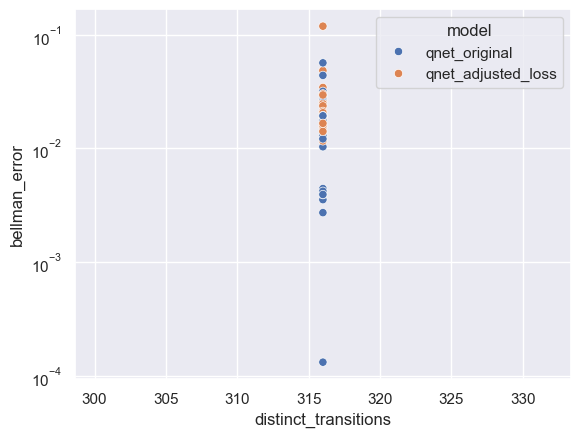

In [102]:
sns.scatterplot(data=df_with_results, x="distinct_transitions", y="bellman_error", hue="model")
# plt.xscale("log")
plt.yscale("log")
plt.show()

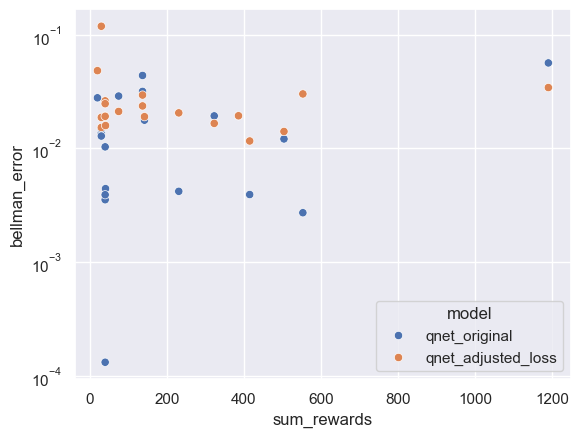

In [103]:
sns.scatterplot(data=df_with_results, x="sum_rewards", y="bellman_error", hue="model")
# plt.xscale("log")
plt.yscale("log")
plt.show()

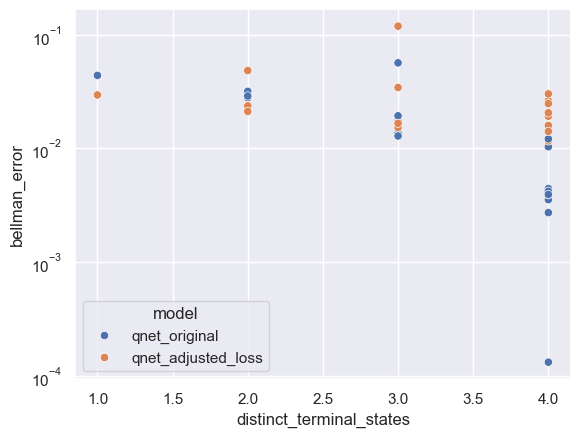

In [104]:
sns.scatterplot(data=df_with_results, x="distinct_terminal_states", y="bellman_error", hue="model")
# plt.xscale("log")
plt.yscale("log")
plt.show()

In [105]:
# IF the results are similar, focus on experiments with failure to train

# TODO: try SGD instad of ADAM

# TODO: renormalize dataset frequencies instead of adjusting loss function


C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\1796716979.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Transitions", y="Counts", data=df, palette="viridis")


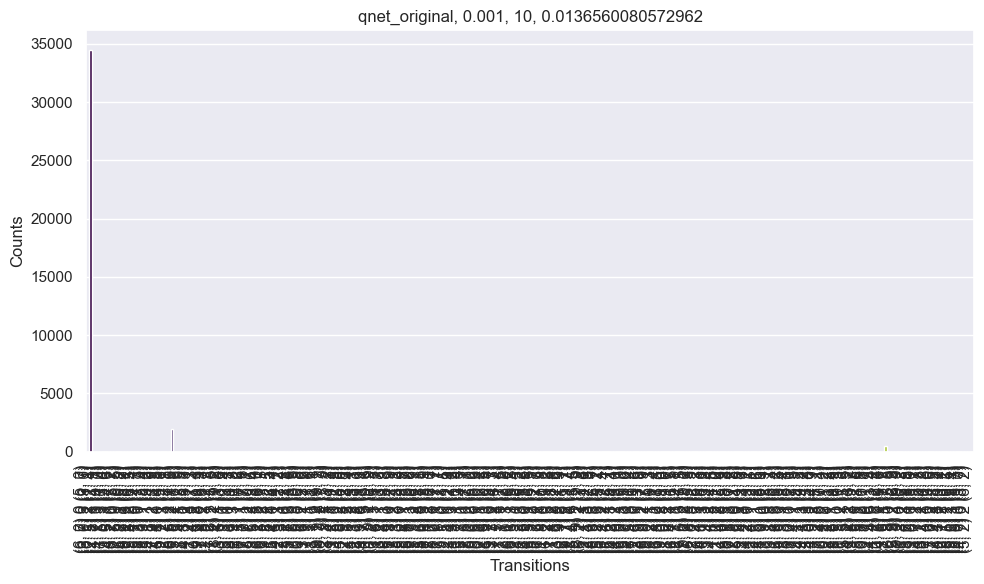

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\1796716979.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Transitions", y="Counts", data=df, palette="viridis")


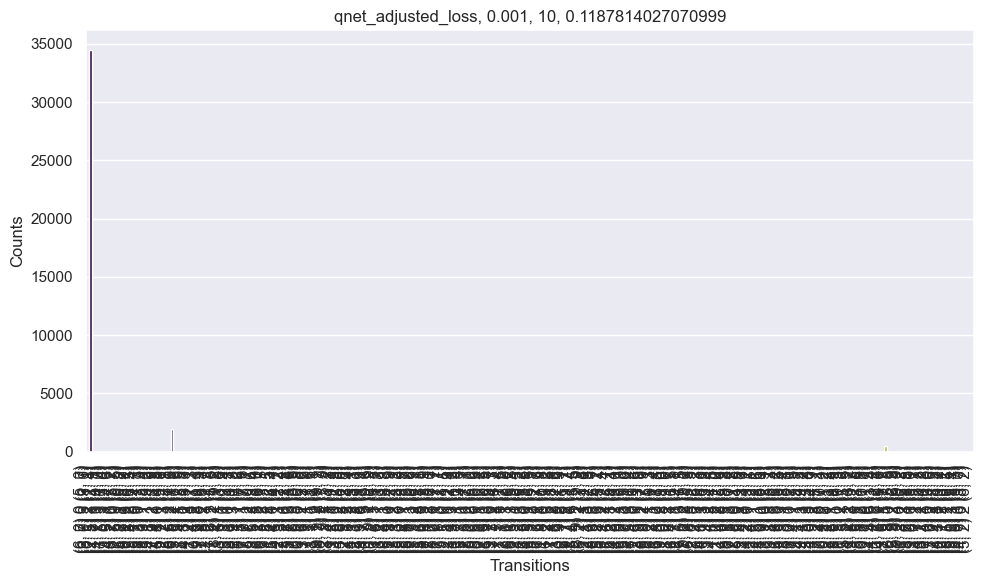

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\1796716979.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Transitions", y="Counts", data=df, palette="viridis")


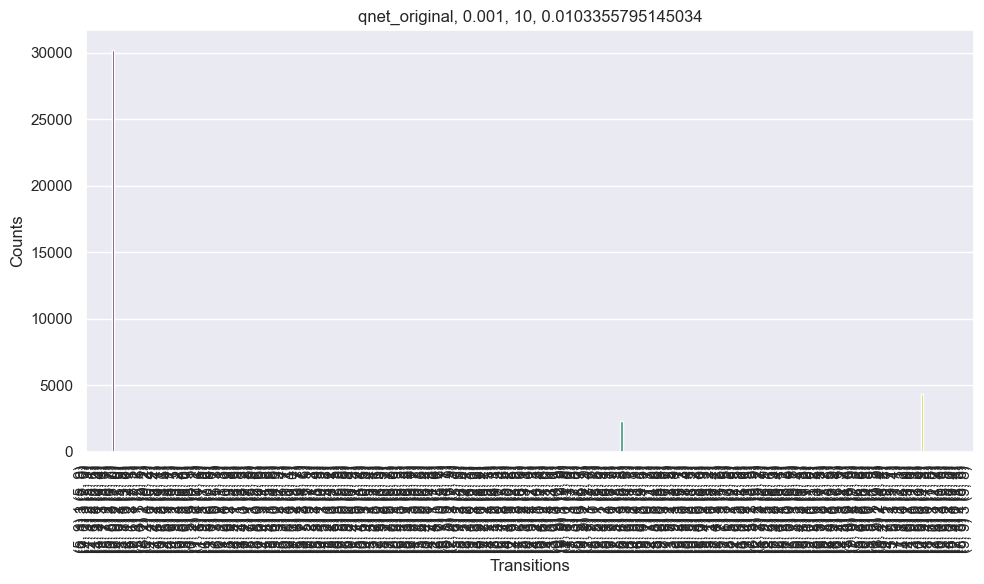

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\1796716979.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Transitions", y="Counts", data=df, palette="viridis")


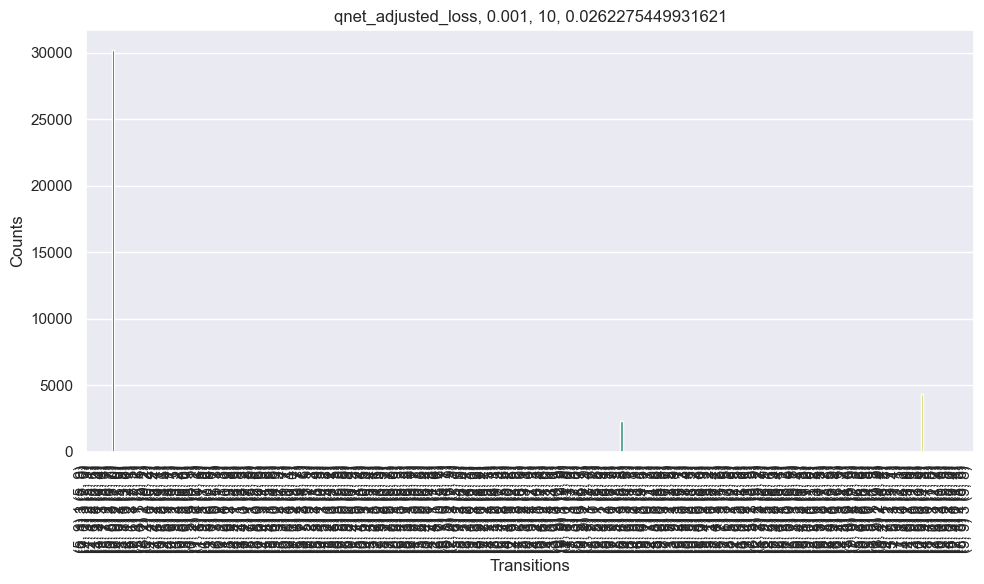

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\1796716979.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Transitions", y="Counts", data=df, palette="viridis")


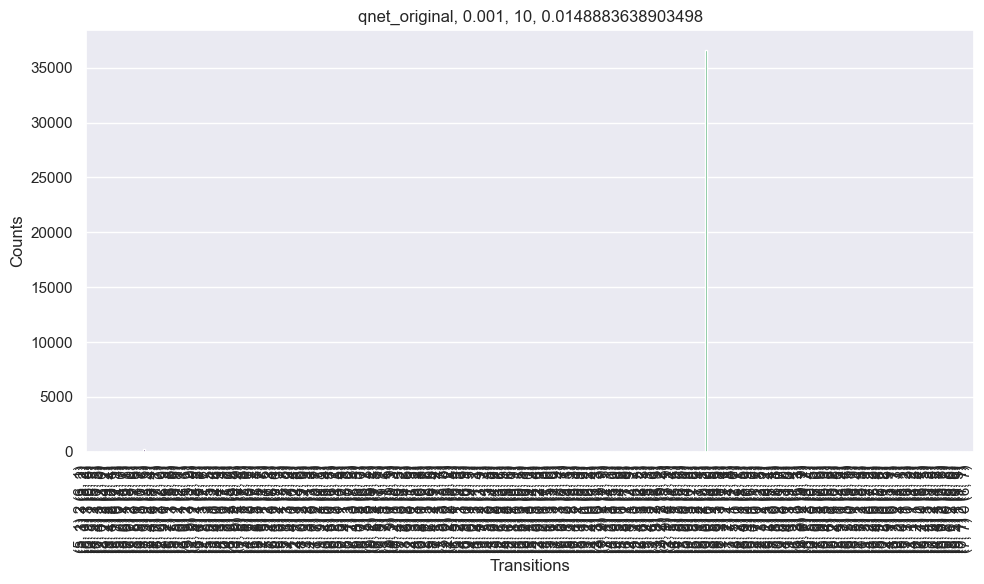

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\1796716979.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Transitions", y="Counts", data=df, palette="viridis")


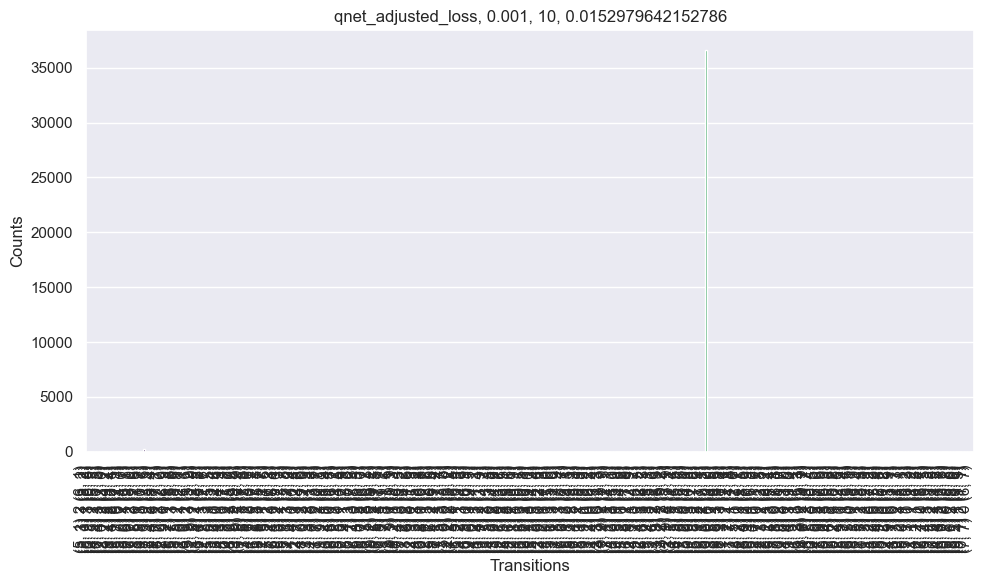

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\1796716979.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Transitions", y="Counts", data=df, palette="viridis")


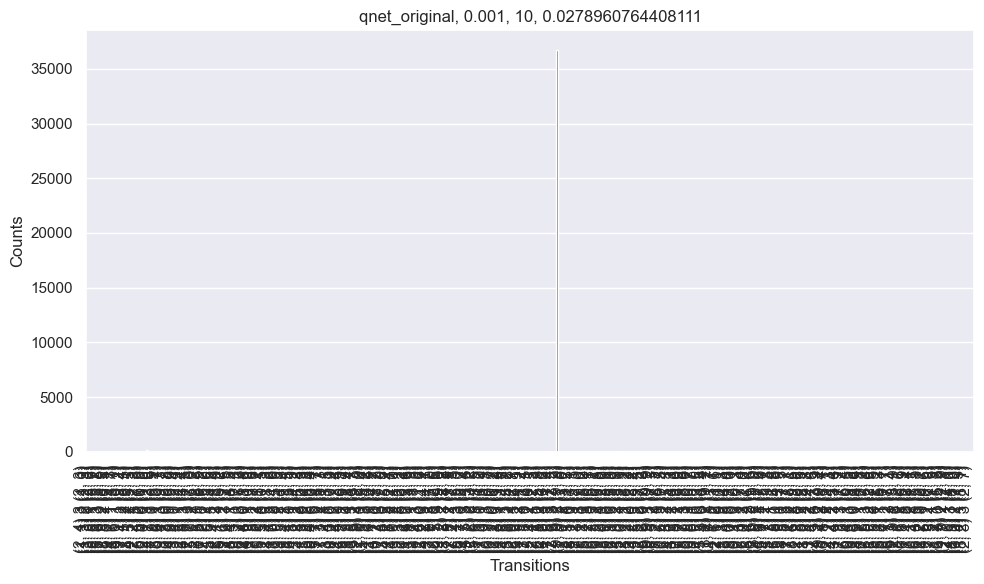

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\1796716979.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Transitions", y="Counts", data=df, palette="viridis")


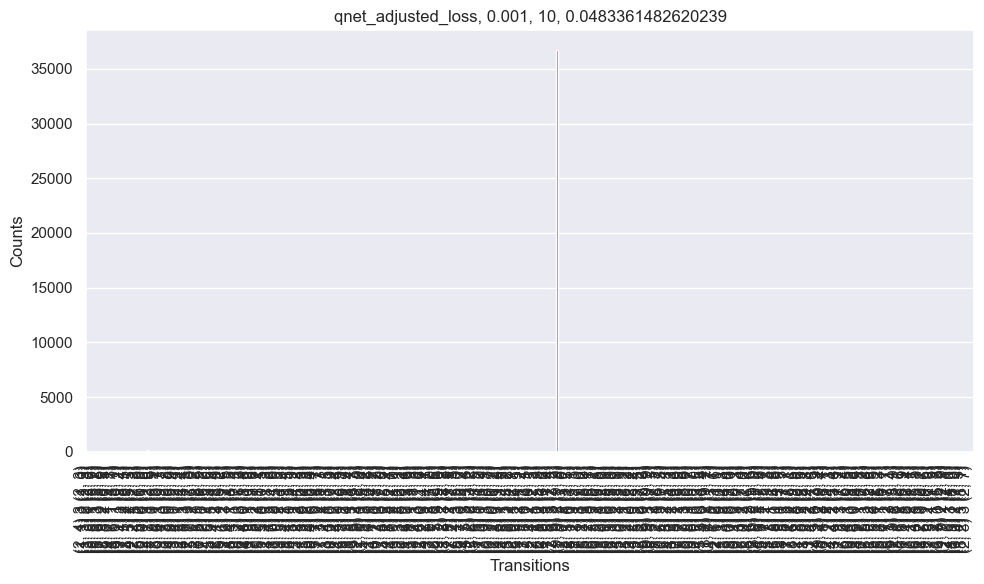

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\1796716979.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Transitions", y="Counts", data=df, palette="viridis")


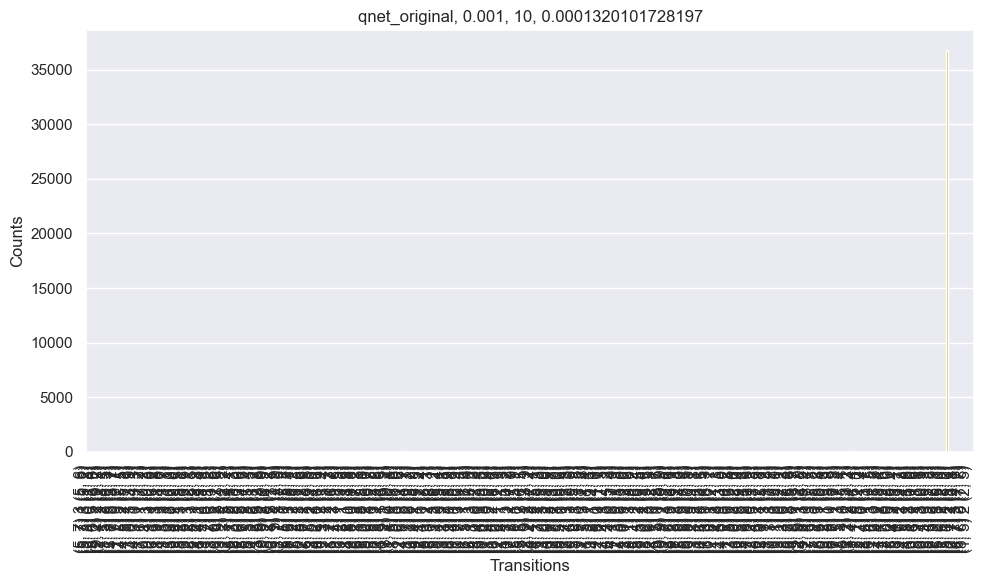

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\1796716979.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Transitions", y="Counts", data=df, palette="viridis")


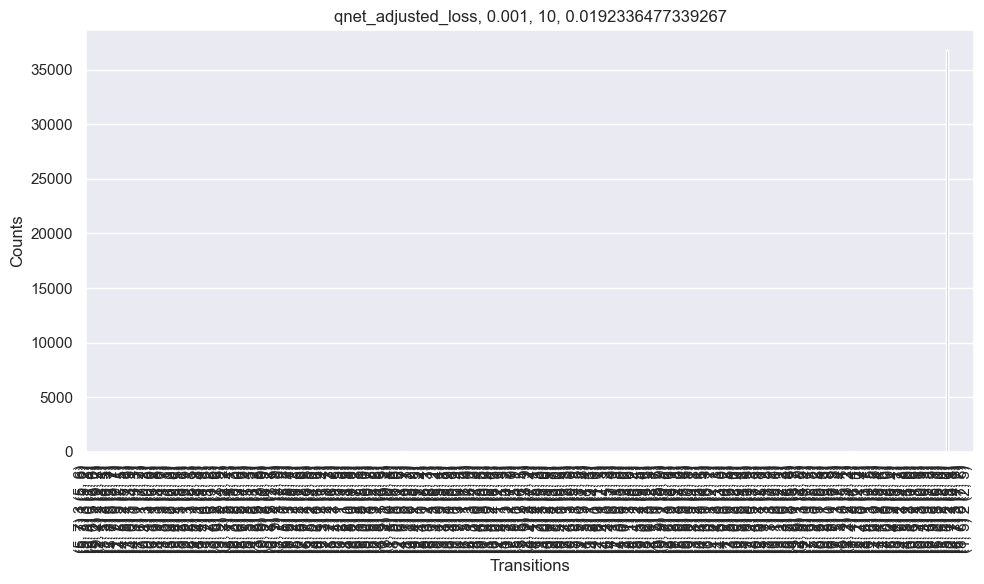

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\1796716979.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Transitions", y="Counts", data=df, palette="viridis")


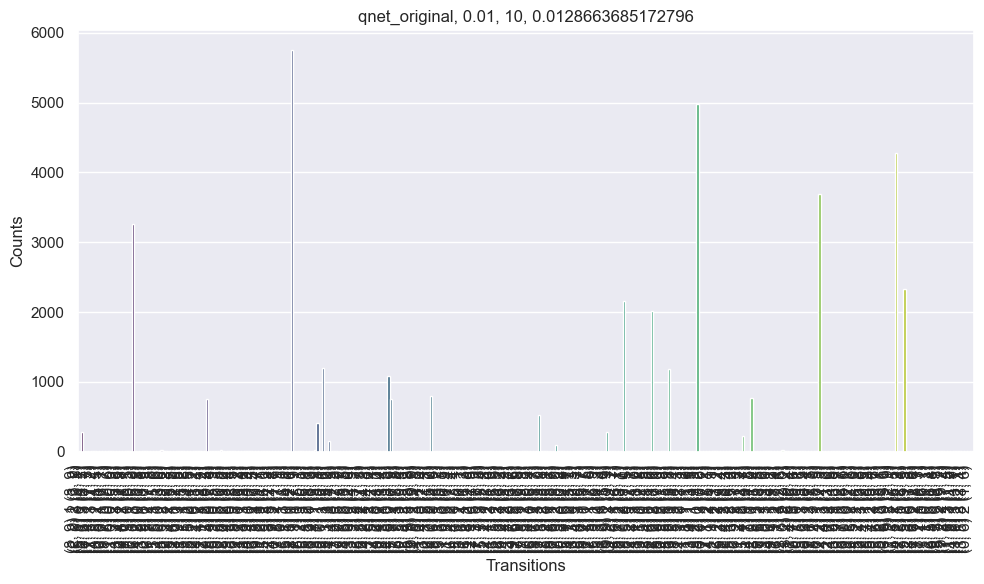

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\1796716979.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Transitions", y="Counts", data=df, palette="viridis")


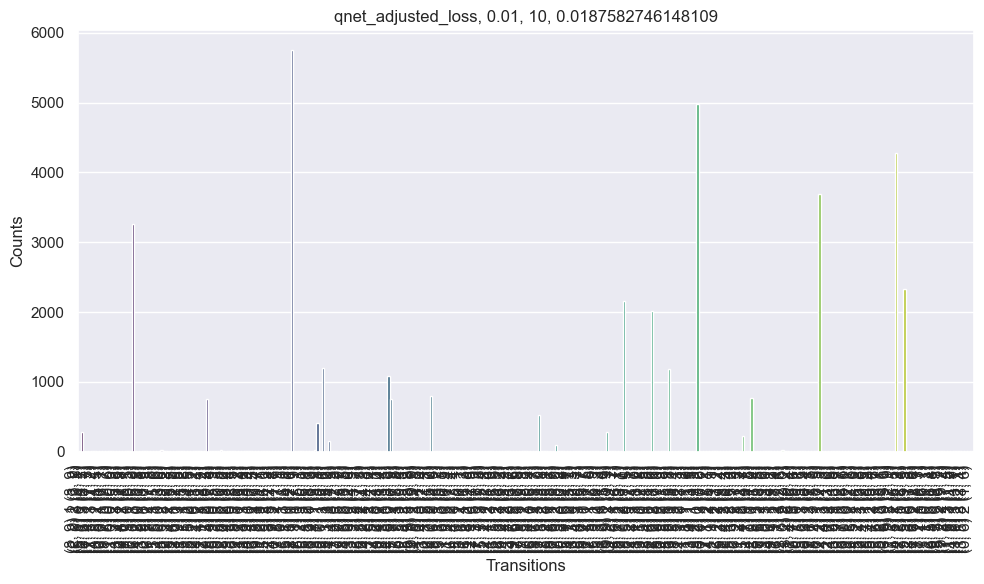

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\1796716979.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Transitions", y="Counts", data=df, palette="viridis")


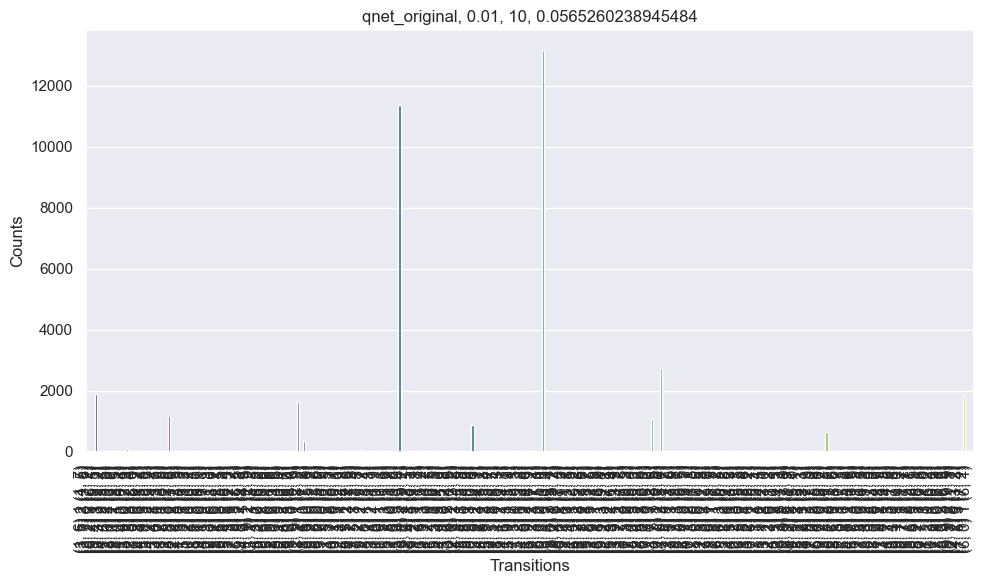

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\1796716979.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Transitions", y="Counts", data=df, palette="viridis")


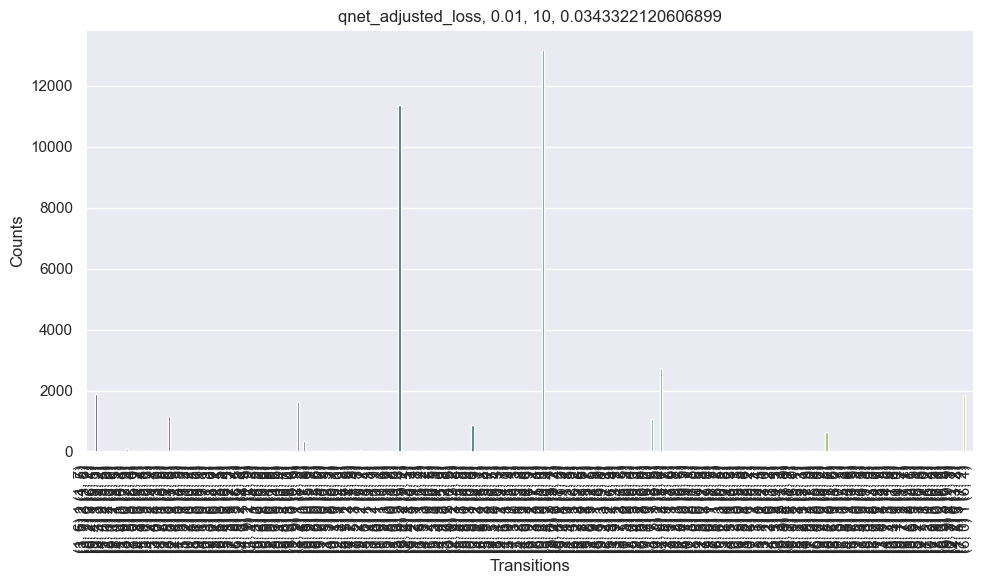

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\1796716979.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Transitions", y="Counts", data=df, palette="viridis")


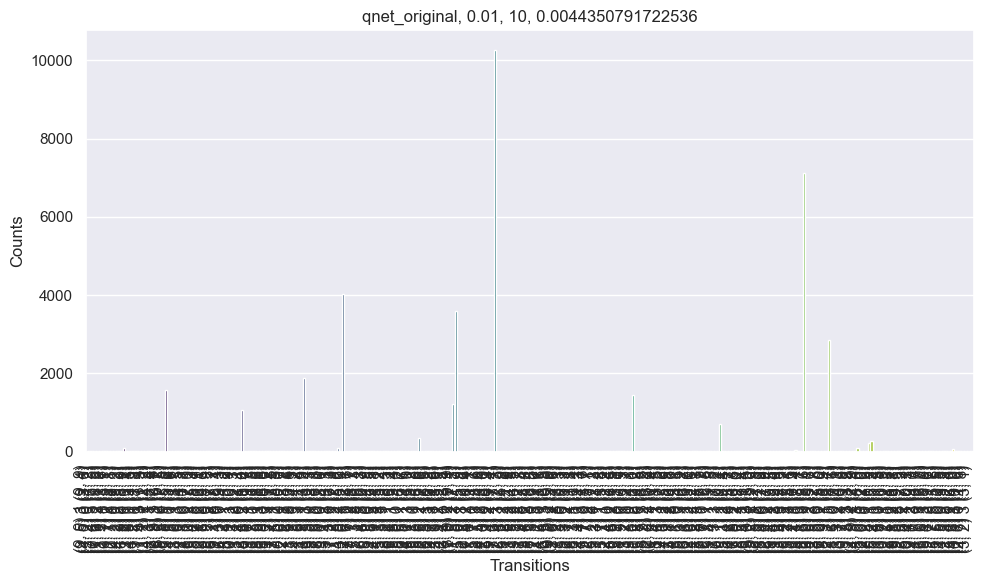

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\1796716979.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Transitions", y="Counts", data=df, palette="viridis")


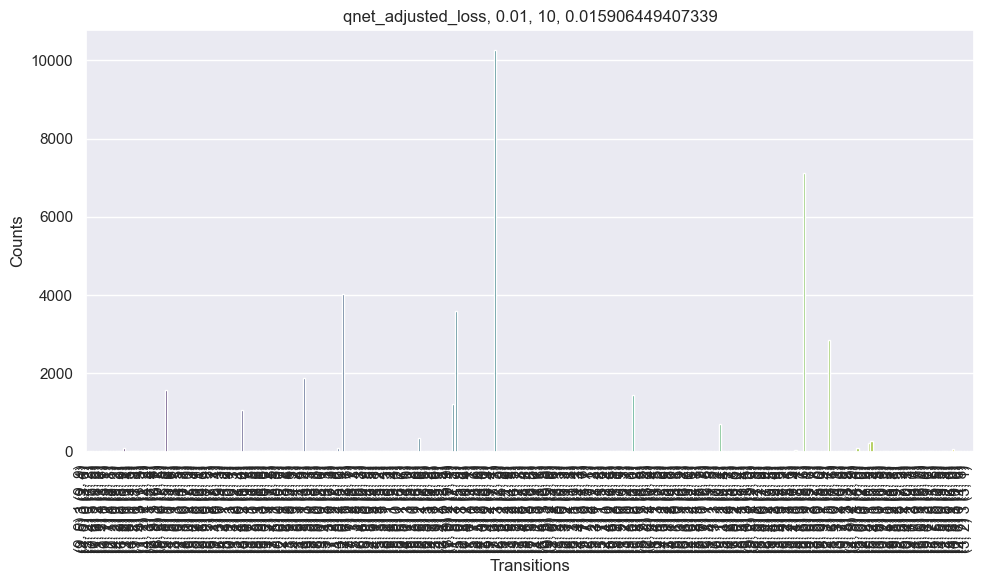

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\1796716979.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Transitions", y="Counts", data=df, palette="viridis")


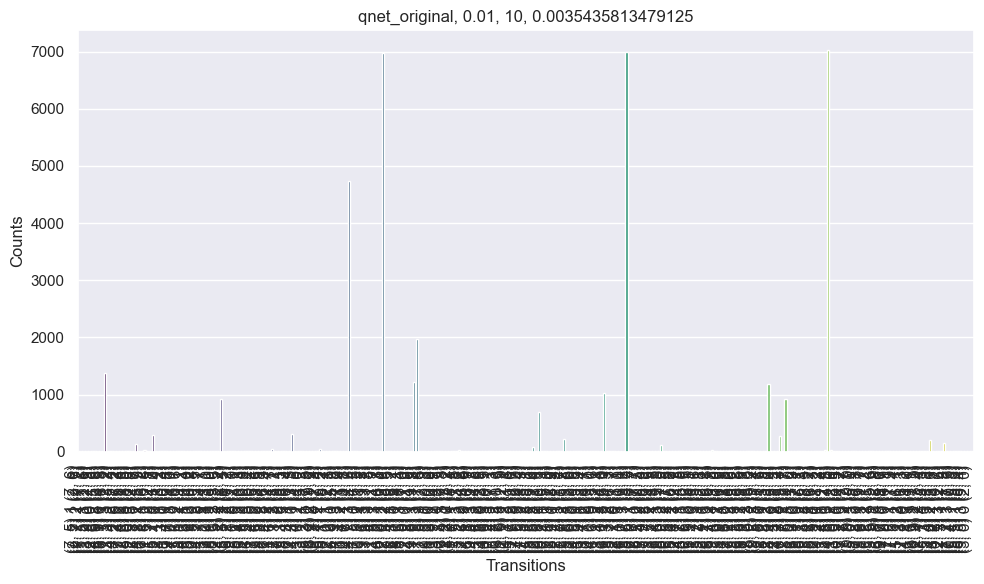

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\1796716979.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Transitions", y="Counts", data=df, palette="viridis")


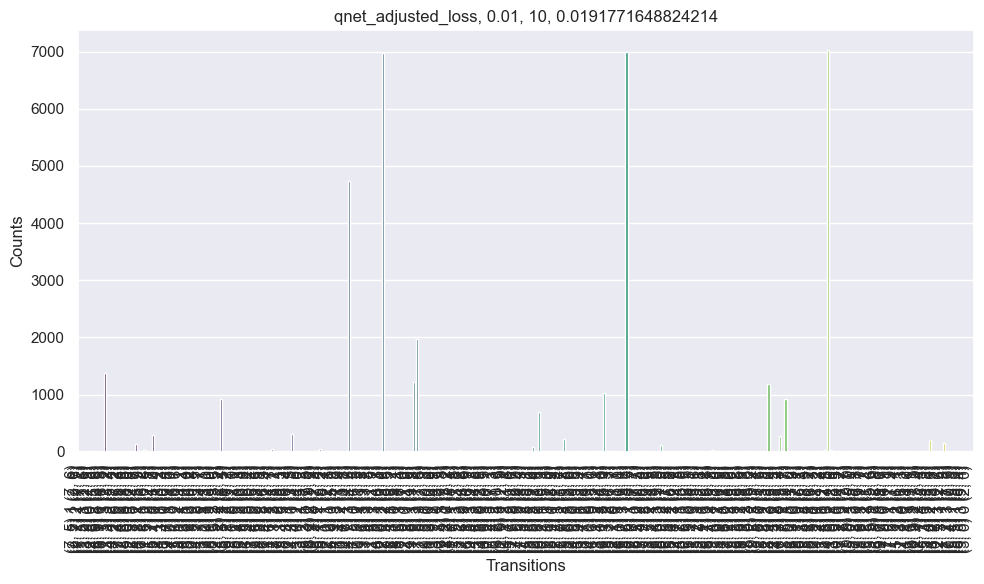

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\1796716979.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Transitions", y="Counts", data=df, palette="viridis")


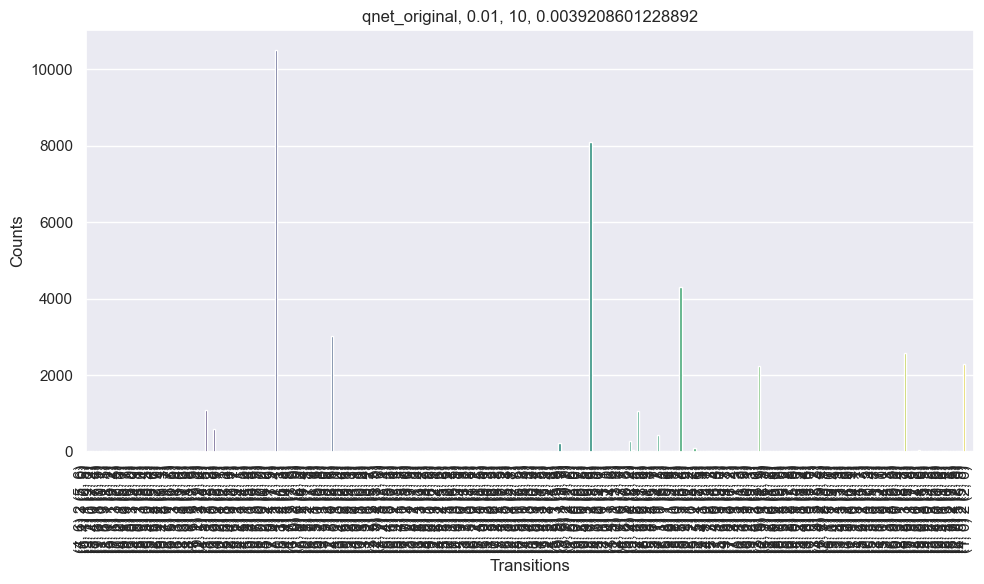

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\1796716979.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Transitions", y="Counts", data=df, palette="viridis")


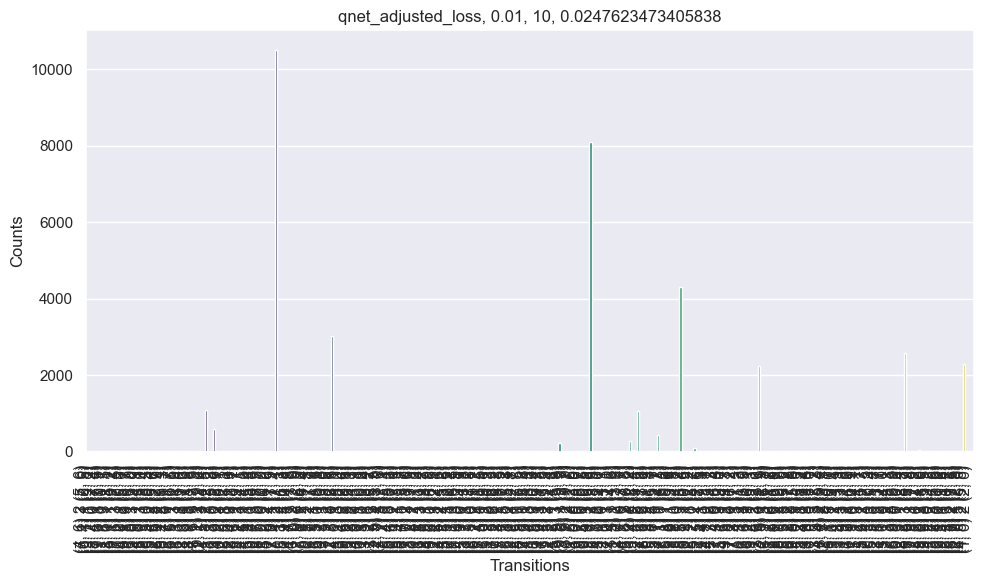

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\1796716979.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Transitions", y="Counts", data=df, palette="viridis")


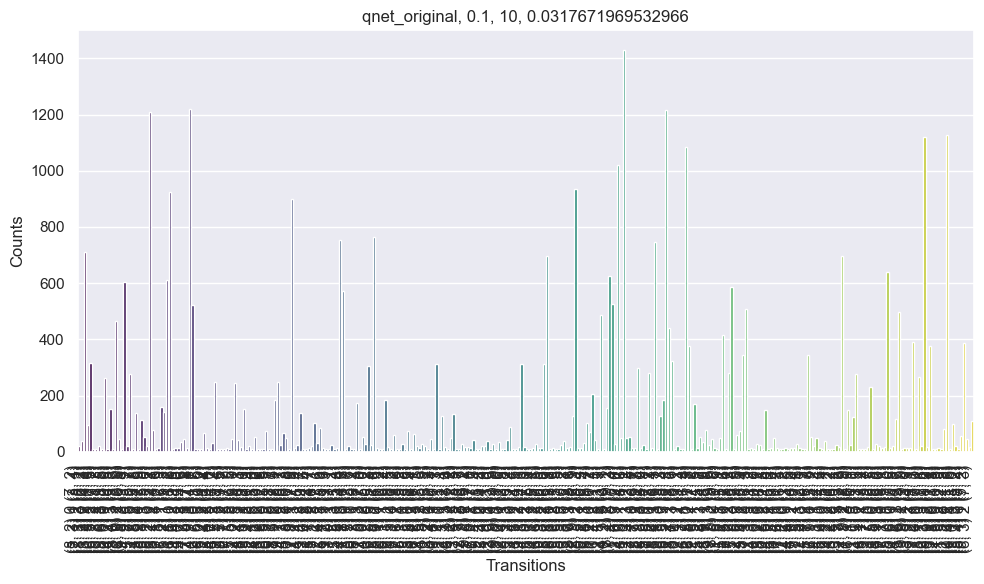

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\1796716979.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Transitions", y="Counts", data=df, palette="viridis")


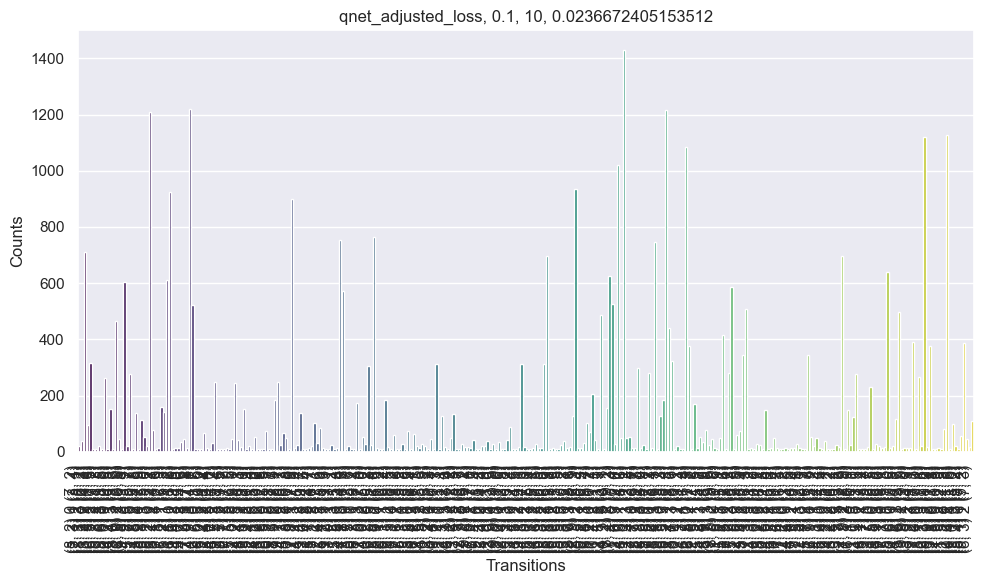

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\1796716979.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Transitions", y="Counts", data=df, palette="viridis")


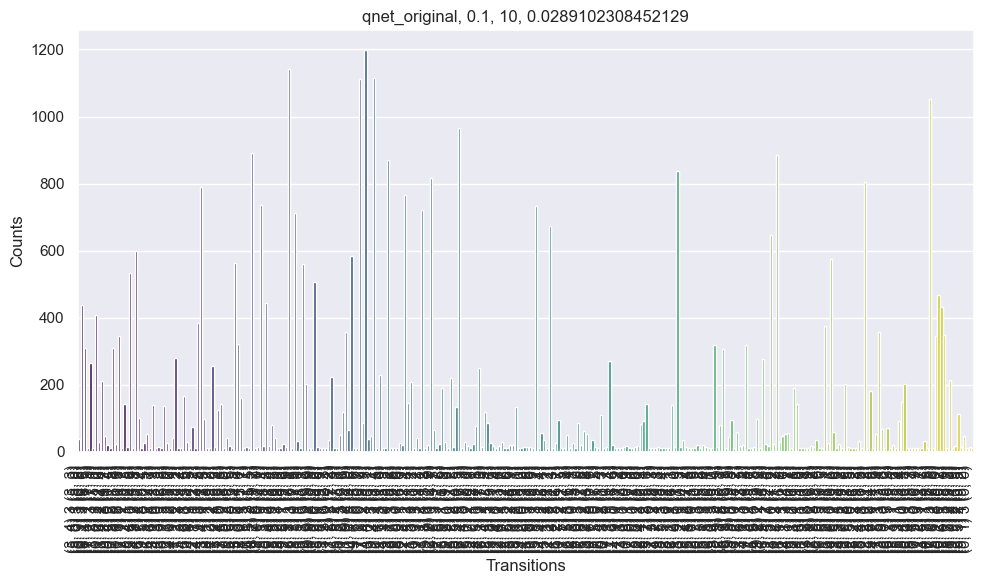

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\1796716979.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Transitions", y="Counts", data=df, palette="viridis")


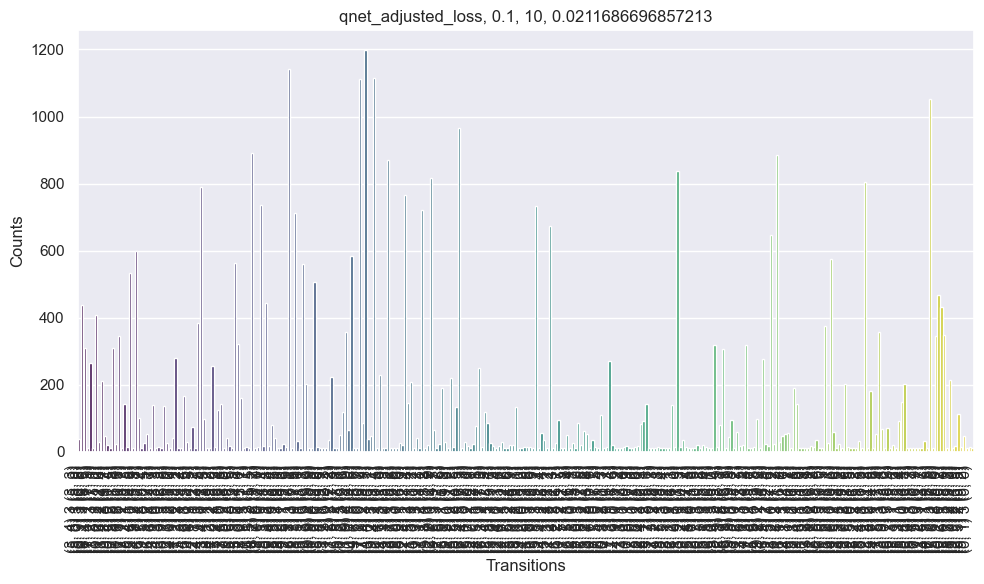

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\1796716979.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Transitions", y="Counts", data=df, palette="viridis")


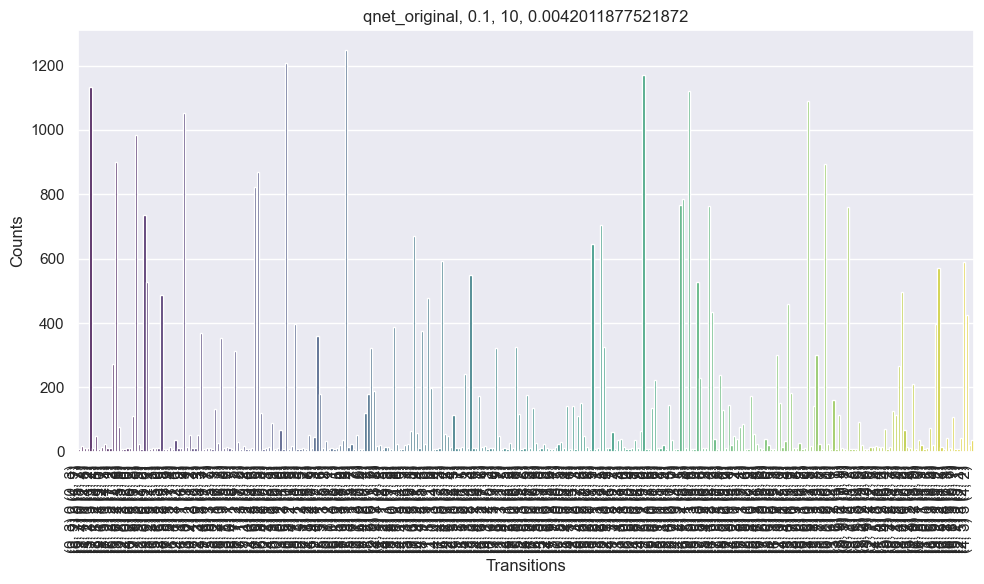

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\1796716979.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Transitions", y="Counts", data=df, palette="viridis")


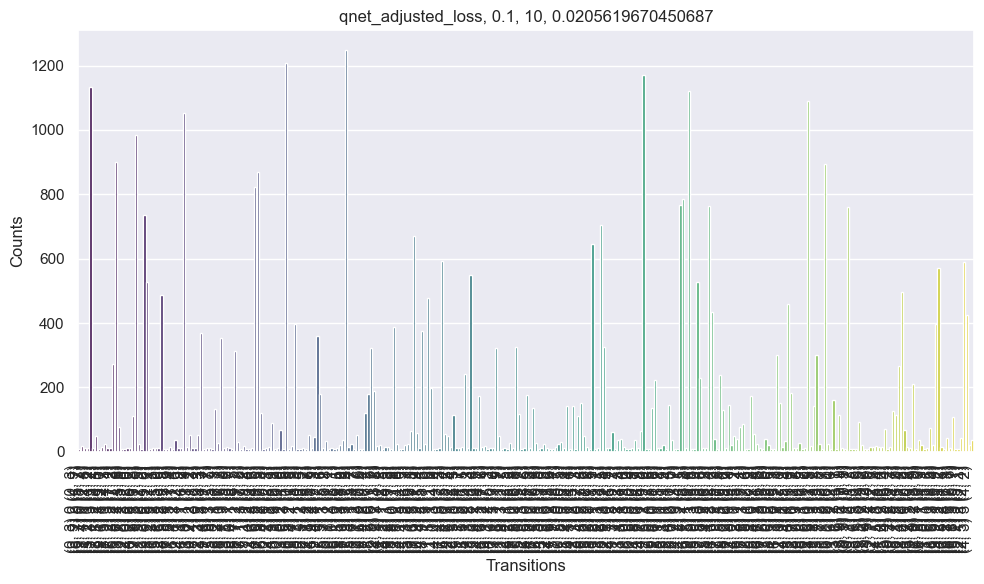

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\1796716979.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Transitions", y="Counts", data=df, palette="viridis")


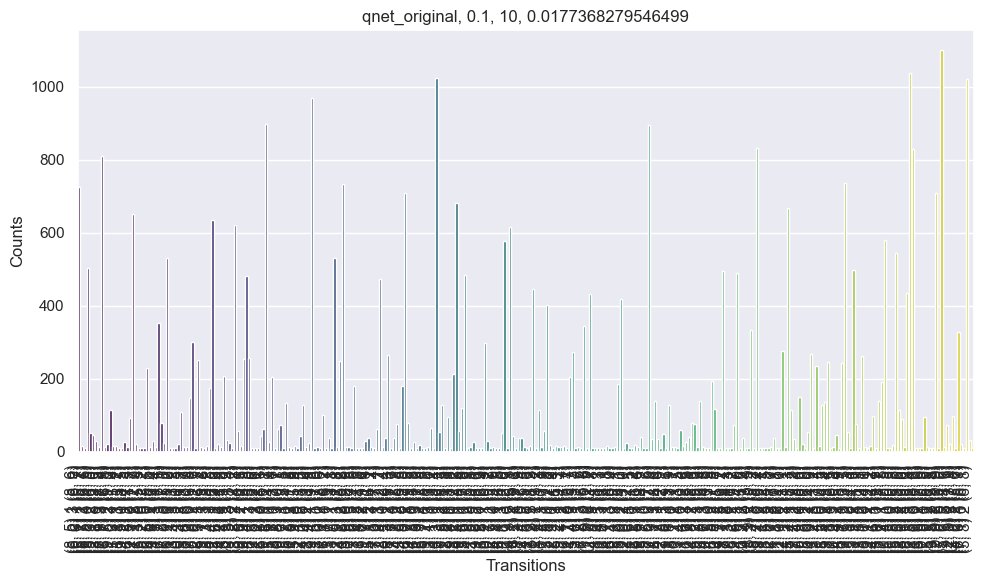

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\1796716979.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Transitions", y="Counts", data=df, palette="viridis")


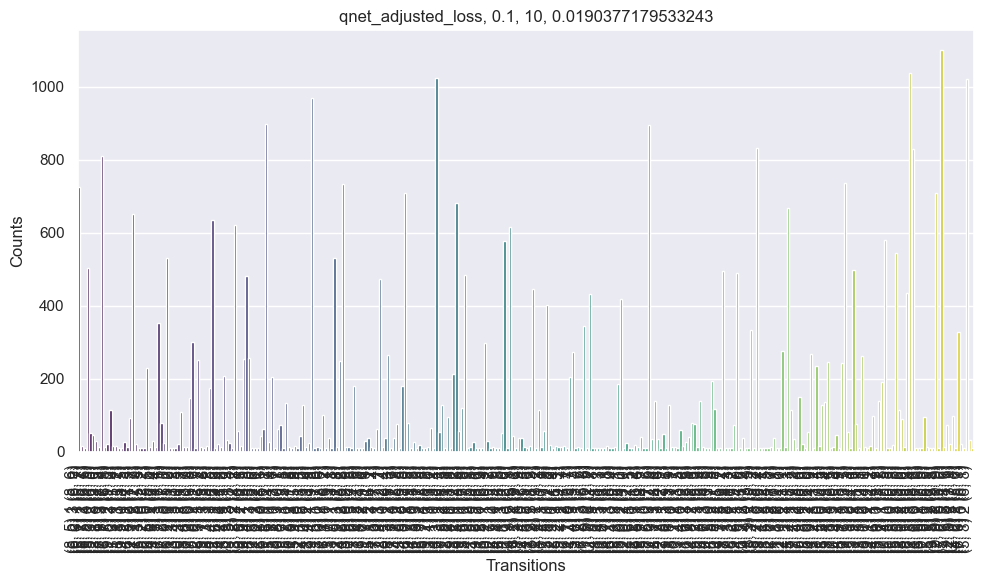

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\1796716979.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Transitions", y="Counts", data=df, palette="viridis")


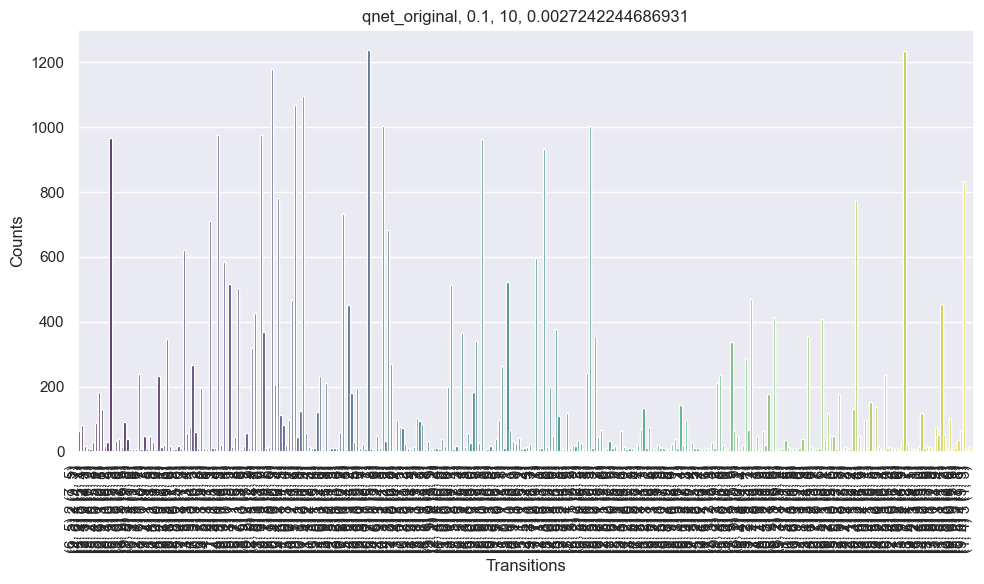

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\1796716979.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Transitions", y="Counts", data=df, palette="viridis")


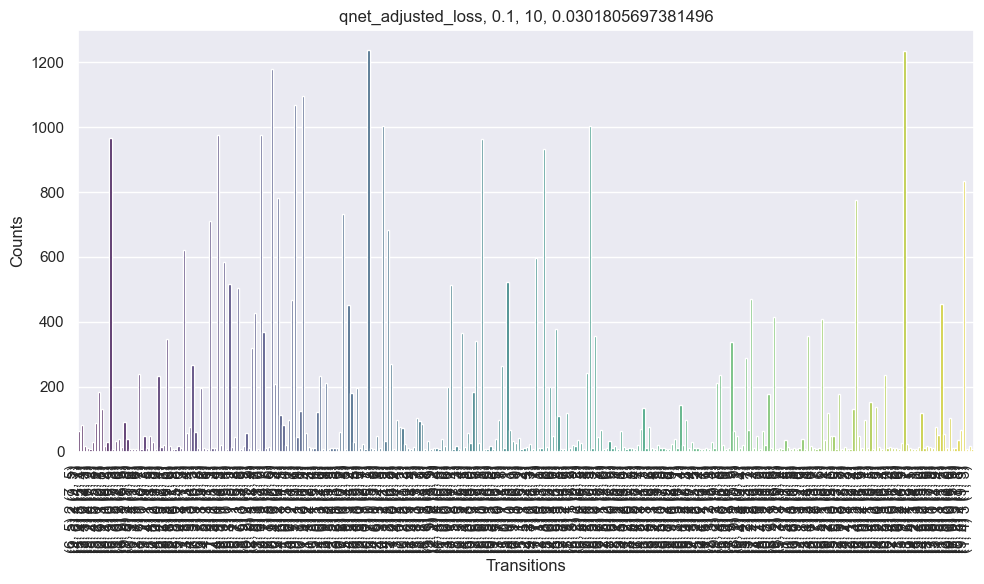

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\1796716979.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Transitions", y="Counts", data=df, palette="viridis")


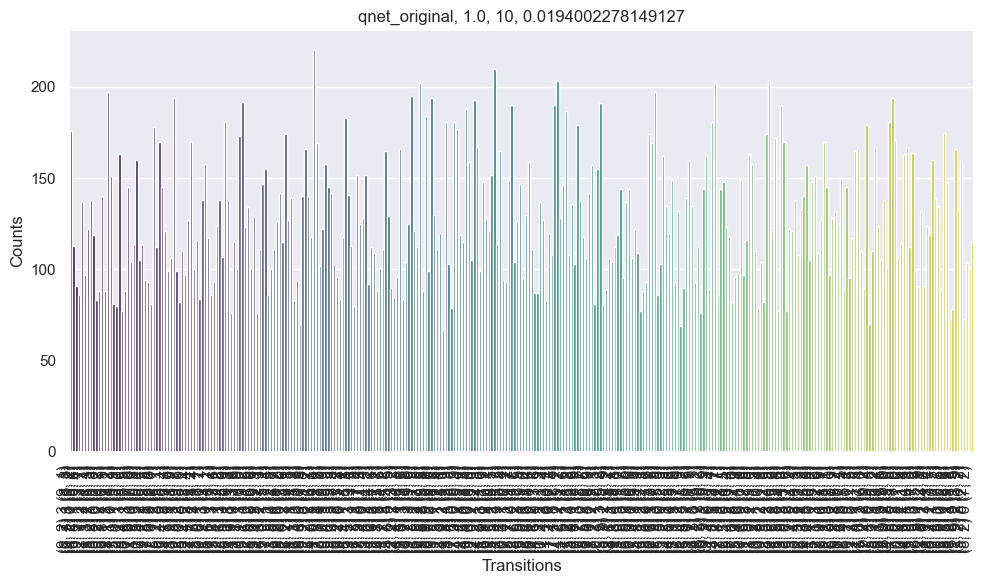

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\1796716979.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Transitions", y="Counts", data=df, palette="viridis")


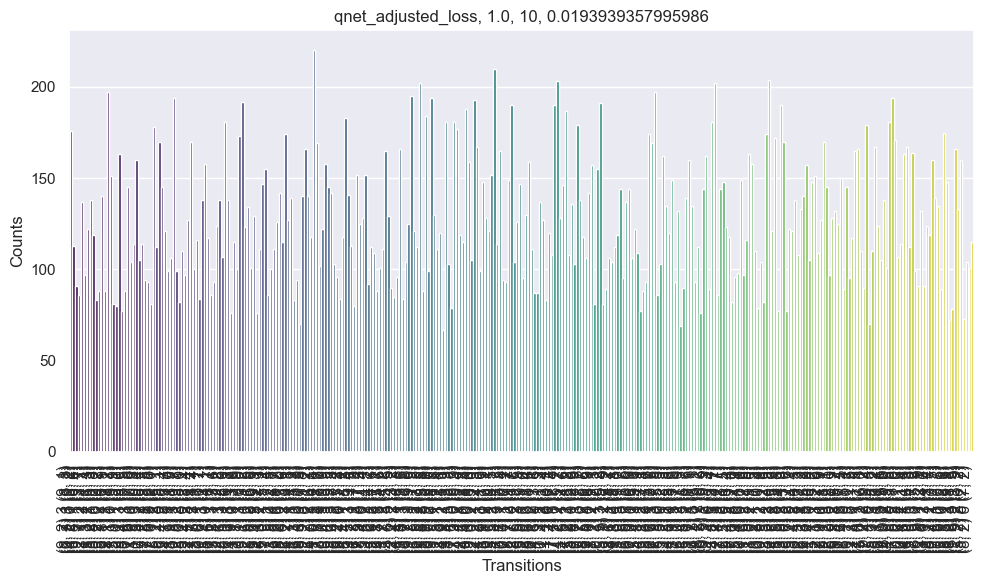

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\1796716979.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Transitions", y="Counts", data=df, palette="viridis")


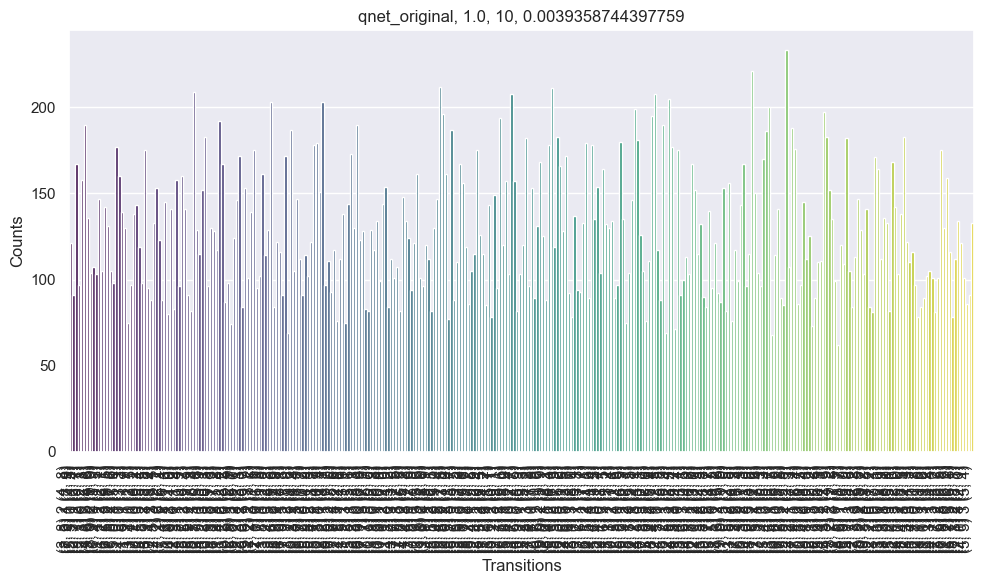

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\1796716979.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Transitions", y="Counts", data=df, palette="viridis")


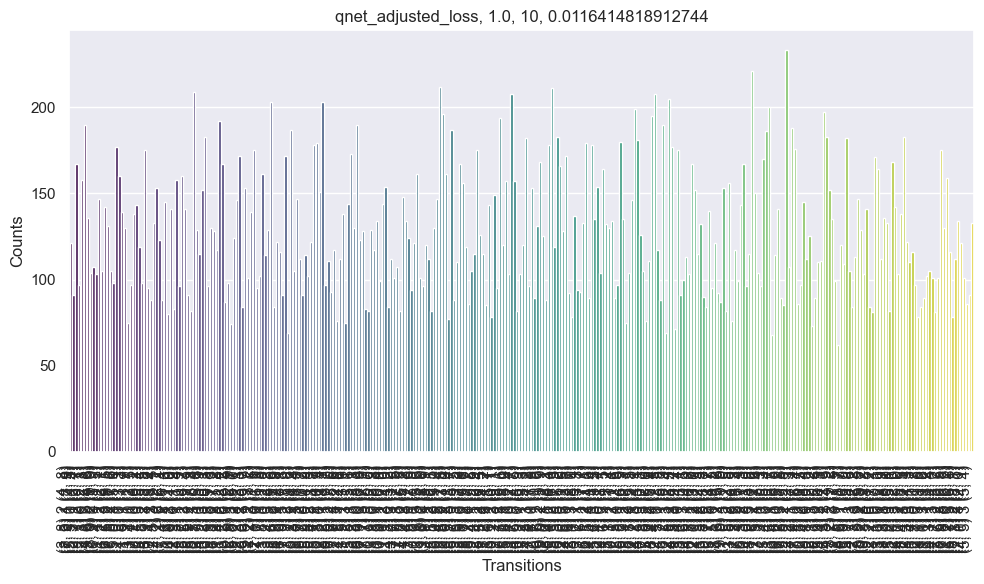

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\1796716979.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Transitions", y="Counts", data=df, palette="viridis")


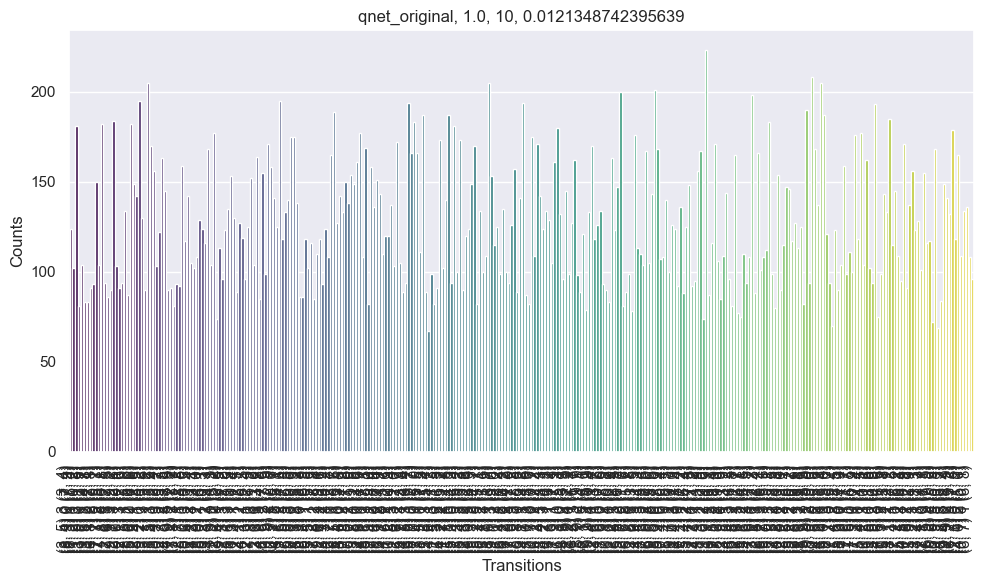

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\1796716979.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Transitions", y="Counts", data=df, palette="viridis")


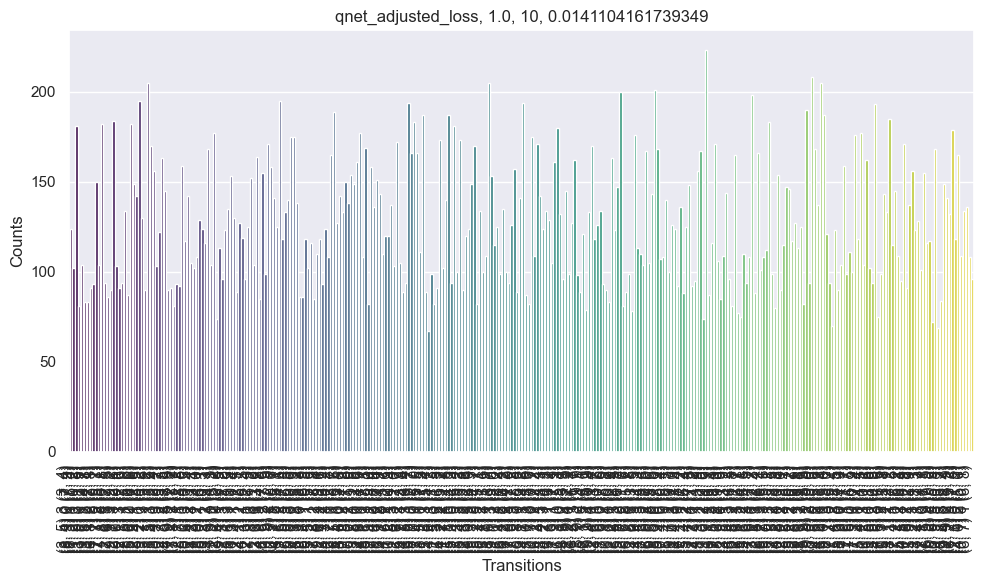

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\1796716979.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Transitions", y="Counts", data=df, palette="viridis")


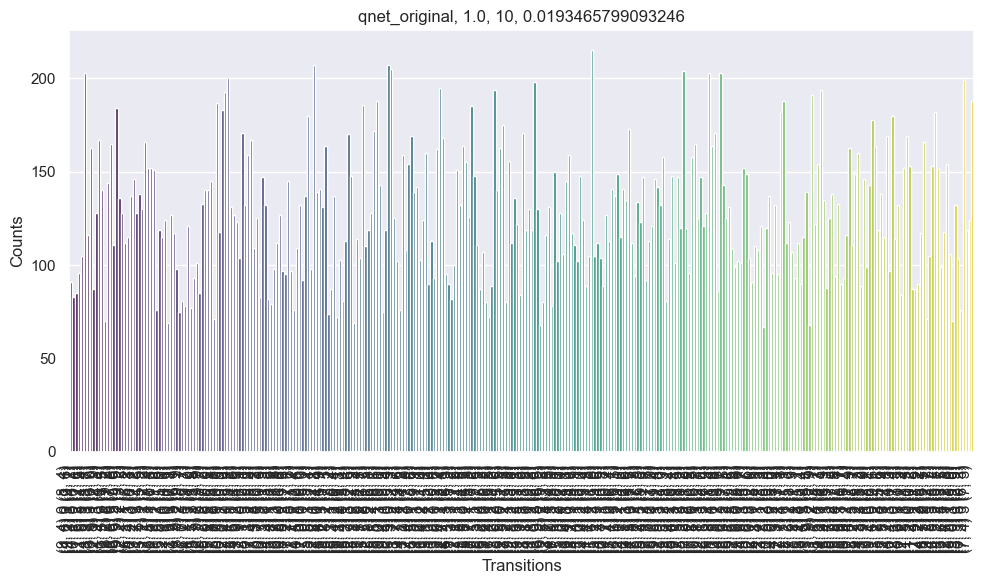

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\1796716979.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Transitions", y="Counts", data=df, palette="viridis")


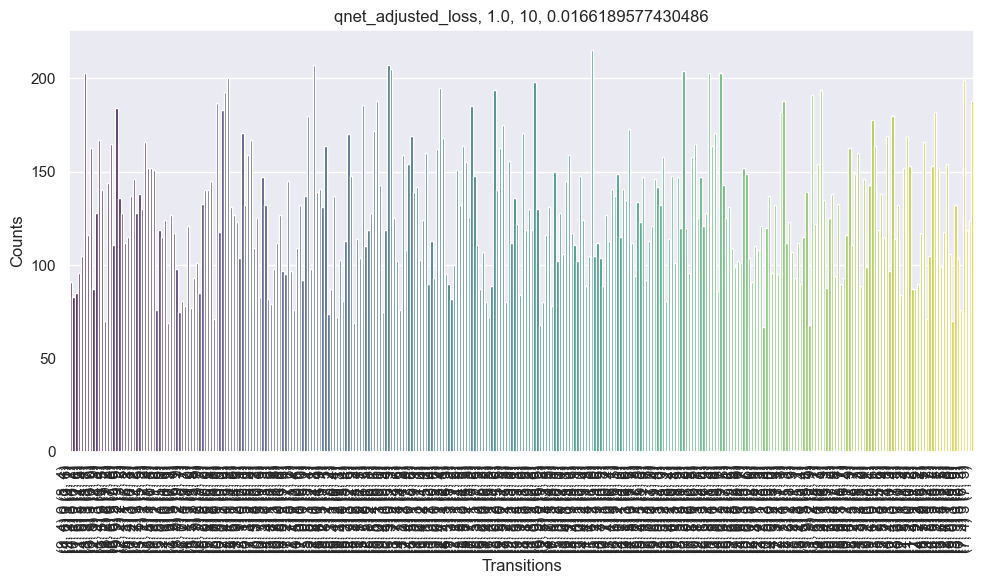

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\1796716979.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Transitions", y="Counts", data=df, palette="viridis")


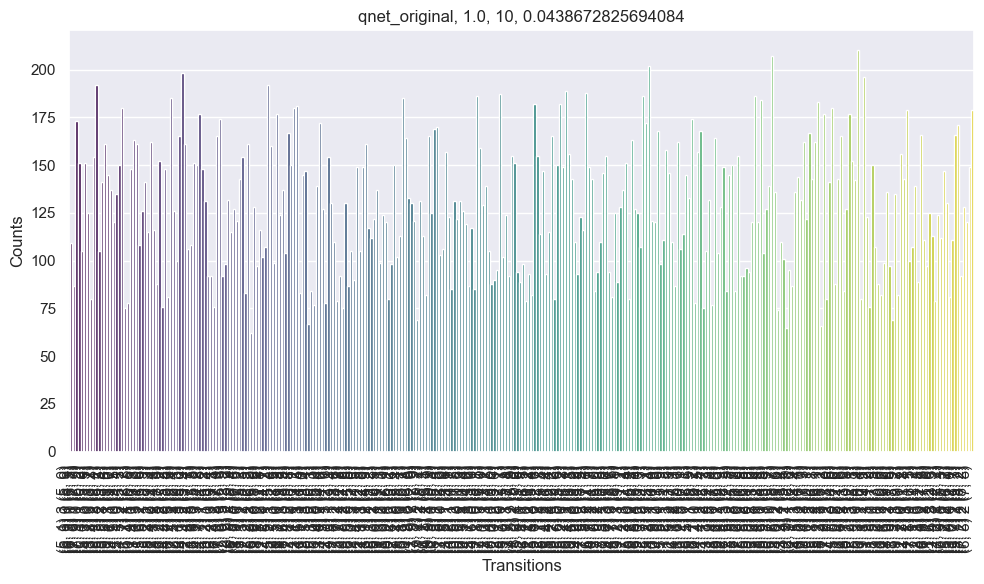

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\1796716979.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Transitions", y="Counts", data=df, palette="viridis")


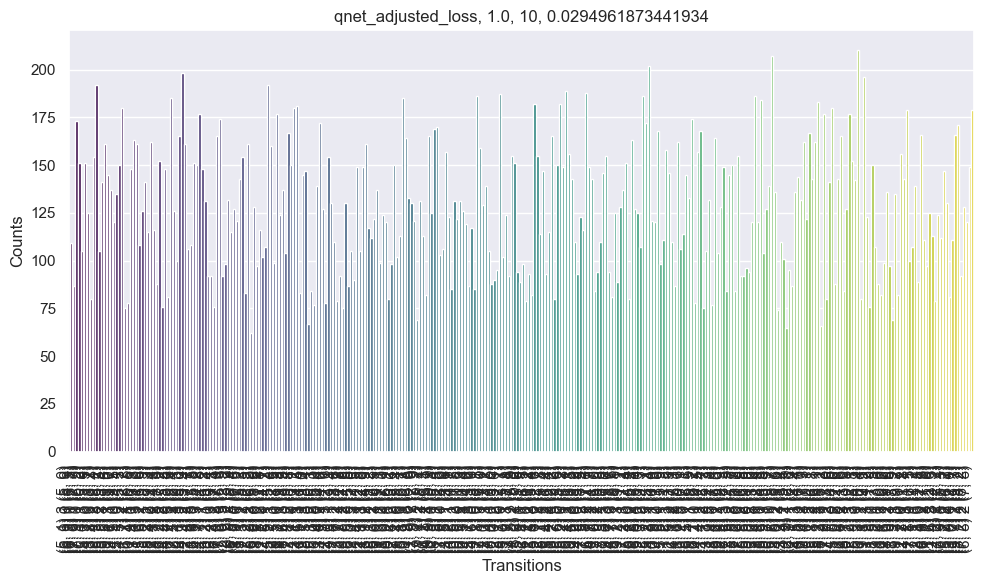

In [106]:
### Histogram of transitions
for index, row in bellman_errors_df.iterrows():
    terminal_states = {(8, 8): 1.0}  
    start_state = (1, 1)
    
    # Call experiment_sample with the current row's data
    train_dataset_transitions = experiment_sample(
        seed=row['seed'],
        start_state=start_state,
        terminal_states=terminal_states,
        rows=row['rows'],
        cols=row['cols'],
        p_success=row['p_success'],
        num_steps=row['num_steps'],
        tau=row['tau'],
        min_samples=row['min_samples'],
    )
    
    # # Compute the desired metrics
    # sum_of_rewards = sum_rewards(train_dataset_transitions)
    # terminal_t_counts = count_transitions_terminal(train_dataset_transitions)
    transition_counts = count_transitions(train_dataset_transitions)
    

    data = {
        "Transitions": [f"{key[0]} {key[1]} {key[2]}" for key in transition_counts.keys()],
        "Counts": list(transition_counts.values())
    }
    
    df = pd.DataFrame(data)
    plt.figure(figsize=(10, 6)) 
    sns.barplot(x="Transitions", y="Counts", data=df, palette="viridis")

    # Adding titles and labels
    plt.title(f'{row["model"]}, {row["tau"]}, {row["min_samples"]}, {row["bellman_error"]}')
    plt.xlabel('Transitions')
    plt.ylabel('Counts')
    plt.xticks(rotation=90, ha="right") 

    # Display the plot
    plt.tight_layout()  
    plt.show()
  

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\2157596148.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.barplot(
C:\Users\Chainsword\AppData\Local\Temp\ipykernel_29116\2157596148.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


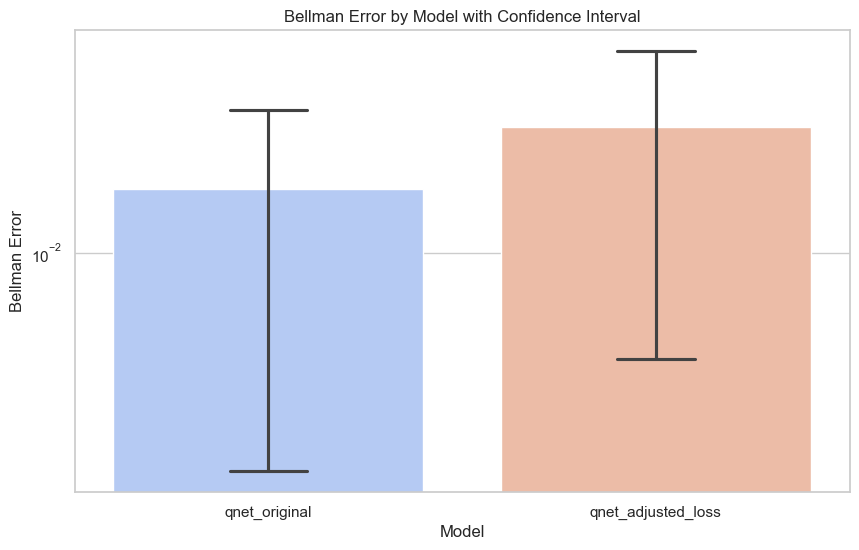

In [107]:
# Assuming your DataFrame is named df
sns.set_theme(style="whitegrid")  # Setting the theme for the plots

plt.figure(figsize=(10, 6))  # Setting the figure size
ax = sns.barplot(
    x="model",
    y="bellman_error",
    data=bellman_errors_df,
    ci="sd",
    palette="coolwarm",
    capsize=0.2,
)

plt.title("Bellman Error by Model with Confidence Interval")
plt.ylabel("Bellman Error")
plt.xlabel("Model")
plt.yscale(
    "log"
)  # Optional: use logarithmic scale for better visualization of wide value ranges

plt.show()